In [1]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR

For this tutorial, we will assume that our task is sentiment analysis.

In [2]:
editor = Editor()

## Minimum Functionality Test (MFT)

A Minimum Functionality Test is like a unit test in Software Engineering.
If you are testing a certain capability (e.g. 'can the model handle negation?'), an MFT is composed of simple examplese that verify a specific behavior.  
Let's create a very simple MFT for negations:

In [3]:
# First, let's find some positive and negative adjectives
', '.join(editor.suggest('This is not {a:mask} {thing}.', thing=['book', 'movie', 'show', 'game'])[:30])

'good, easy, academic, educational, interesting, average, ordinary, old, art, enjoyable, entertaining, ideal, exciting, actual, original, independent, bad, innocent, excellent, amazing, interactive, intelligent, amateur, great, awful, important, introductory, experimental, awards, engaging'

In [4]:
pos = ['good', 'enjoyable', 'exciting', 'excellent', 'amazing', 'great', 'engaging']
neg = ['bad', 'terrible', 'awful', 'horrible']

Now let's create some data with both positive and negative negations, assuming `1` means positive and `0` means negative:

In [5]:
ret = editor.template('This is not {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=100)
ret += editor.template('This is not {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=100)

We can easily turn this data into an MFT:

In [6]:
test = MFT(ret.data, labels=ret.labels, name='Simple negation',
           capability='Negation', description='Very simple negations.')

Since `ret` is a dict where keys have the right names for test arguments, we can also use a simpler call:

In [7]:
test = MFT(**ret, name='Simple negation',
           capability='Negation', description='Very simple negations.')

### Running tests

Let's use an off-the-shelf sentiment analysis model.

In [8]:
from pattern.en import sentiment

In [9]:
import numpy as np
def predict_proba(inputs):
    p1 = np.array([(sentiment(x)[0] + 1)/2. for x in inputs]).reshape(-1, 1)
    p0 = 1- p1
    return np.hstack((p0, p1))

In [10]:
# Predictions are random
predict_proba(['good', 'bad'])

array([[0.15, 0.85],
       [0.85, 0.15]])

There are two ways of running tests.  
In the first (and simplest) way, you pass a function as argument to `test.run`, which gets called to make predictions.  
We assume that the function returns a tuple with `(predictions, confidences)`, so we have a wrapper to turn softmax (like our function above) into this:

In [11]:
from checklist.pred_wrapper import PredictorWrapper
wrapped_pp = PredictorWrapper.wrap_softmax(predict_proba)

In [12]:
wrapped_pp(['good'])

(array([1]), array([[0.15, 0.85]]))

Once you have this function, running the test is as simple as calling `test.run`.  
You can run the test on a subset of testcases (for speed's sake) by specifying `n` if needed.  
We won't do that here since our test is small)

In [13]:
test.run(wrapped_pp)

Predicting 200 examples


Once you run a test, you can print a summary of the results with `test.summary()`

In [14]:
test.summary()

Test cases:      200
Fails (rate):    94 (47.0%)

Example fails:
0.8 This is not an amazing graph.
----
0.0 This is not an awful coincidence.
----
0.8 This is not an enjoyable display.
----


It seems that this off-the-shelf system has trouble with negation.
Note the failures: examples that should be negative are predicted as positive and vice versa (the number shown is the probability of positive)

If you are using jupyter notebooks, you can use `test.visual_summary()` for a nice visualization version of these results:  
(I'll load a gif so you can see this in preview mode)

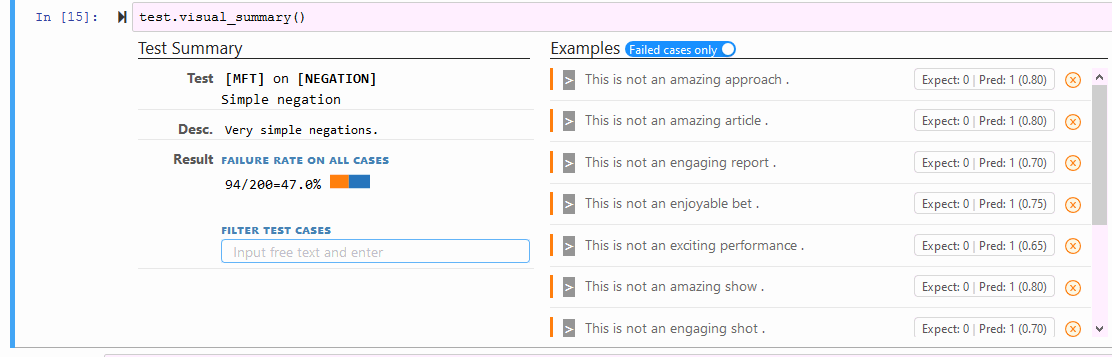

In [17]:
from IPython.display import HTML, Image
with open('visual_summary.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [15]:
test.visual_summary()

TestSummarizer(stats={'npassed': 106, 'nfailed': 94, 'nfiltered': 0}, summarizer={'name': 'Simple negation', '…

The second way to run a test is from a prediction file.  
First, we export the test into a text file:

In [16]:
test.to_raw_file('/tmp/raw_file.txt')

In [17]:
cat /tmp/raw_file.txt | head -n 5

This is not an amazing approach.
This is not a great film.
This is not an amazing article.
This is not an engaging report.
This is not an enjoyable bet.


Then, you get predictions from the examples in the raw file (in order) however you want, and save them in a prediction file.  
Let's simulate this process here:

In [18]:
docs = open('/tmp/raw_file.txt').read().splitlines()
preds = predict_proba(docs)
f = open('/tmp/softmax_preds.txt', 'w')
for p in preds:
    f.write('%f %f\n' % tuple(p))
f.close()

In [19]:
cat /tmp/softmax_preds.txt | head -n 2

0.200000 0.800000
0.700000 0.300000


We can run the test from this file.  
We have to specify the file format (see the API for possible choices), or a function that takes a line in the file and outputs predictions and confidences.  
Since we had already run this test, we have to set `overwrite=True` to overwrite the previous results.

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
test.run_from_file('/tmp/softmax_preds.txt', file_format='softmax', overwrite=True)

In [22]:
test.summary()

Test cases:      200
Fails (rate):    94 (47.0%)

Example fails:
0.8 This is not an amazing approach.
----
0.7 This is not an engaging look.
----
0.0 This is not an awful movie.
----


## Invariance tests

An Invariance test (INV) is when we apply label-preserving perturbations to inputs and expect the model prediction to remain the same.  
Let's start by creating a fictitious dataset to serve as an example, and process it with spacy

In [23]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [24]:
dataset = ['This was a very nice movie directed by John Smith.',
           'Mary Keen was brilliant.', 
          'I hated everything about this.',
          'This movie was very bad.',
          'I really liked this movie.',
          'just bad.',
          'amazing.',
          ]
pdataset = list(nlp.pipe(dataset))

Now let's apply a simple perturbation: changing people's names and expecting predictions to remain the same:

In [25]:
t = Perturb.perturb(pdataset, Perturb.change_names)
print('\n'.join(t.data[0][:3]))
print('...')
test = INV(**t)

This was a very nice movie directed by John Smith.
This was a very nice movie directed by Michael Morris.
This was a very nice movie directed by Christopher Taylor.
...


In [26]:
test.run(wrapped_pp)
test.summary()

Predicting 22 examples
Test cases:      2
Fails (rate):    0 (0.0%)


Let's try a different test: adding typos and expecting predictions to remain the same

In [27]:
t = Perturb.perturb(dataset, Perturb.add_typos)
print('\n'.join(t.data[0][:3]))
print('...')
test = INV(**t)

This was a very nice movie directed by John Smith.
This was a very nice movie directed byJ ohn Smith.
...


In [28]:
test.run(wrapped_pp)
test.summary()

Predicting 14 examples
Test cases:      7
Fails (rate):    2 (28.6%)

Example fails:
0.9 Mary Keen was brilliant.
0.5 Mary Keen was brillinat.

----
0.8 amazing.
0.5 amaizng.

----


## Directional Expectation tests

A Directional Expectation test (DIR) is just like an INV, in the sense that we apply a perturbation to existing inputs. However, instead of expecting invariance, we expect the model to behave in a some specified way.

For example, let's start with a very simple perturbation: we'll add very negative phrases to the end of our small dataset:

In [29]:
def add_negative(x):
    phrases = ['Anyway, I thought it was bad.', 'Having said this, I hated it', 'The director should be fired.']
    return ['%s %s' % (x, p) for p in phrases]

In [30]:
dataset[0], add_negative(dataset[0])

('This was a very nice movie directed by John Smith.',
 ['This was a very nice movie directed by John Smith. Anyway, I thought it was bad.',
  'This was a very nice movie directed by John Smith. Having said this, I hated it',
  'This was a very nice movie directed by John Smith. The director should be fired.'])

What would we expect after this perturbation? I think the least we should expect is that the prediction probability of positive should **not go up** (that is, it should be monotonically decreasing).  
Monotonicity is an expectation function that is built in, so we don't need to implement it.
`tolerance=0.1` means we won't consider it a failure if the prediction probability goes up by less than 0.1, only if it goes up by more

In [31]:
from checklist.expect import Expect

In [32]:
monotonic_decreasing = Expect.monotonic(label=1, increasing=False, tolerance=0.1)

In [33]:
t = Perturb.perturb(dataset, add_negative)
test = DIR(**t, expect=monotonic_decreasing)

In [34]:
test.run(wrapped_pp)
test.summary()

Predicting 28 examples
Test cases:      7
After filtering: 6 (85.7%)
Fails (rate):    0 (0.0%)


#### Writing custom expectation functions

If you are writing a custom expectation functions, it must return a float or bool for each example such that:
- `> 0` (or True) means passed,
- `<= 0` or False means fail, and (optionally) the magnitude of the failure, indicated by distance from 0, e.g. -10 is worse than -1
- `None` means the test does not apply, and this should not be counted

Each test case can have multiple examples. In our MFTs, each test case only had a single example, but in our INVs and DIRs, they had multiple examples (e.g. we changed people's names to various other names).

You can write custom expectation functions at multiple levels of granularity.  


#### Expectation on a single example

If you want to write an expectation function that acts on each individual example, you write a function with the following signature:

`def fn(x, pred, conf, label=None, meta=None):`

For example, let's write a (useless) expectation function that checks that every prediction confidence is higher than 0.95:

In [35]:
# Function that expects prediction confidence to always be more than 0.9
def high_confidence(x, pred, conf, label=None, meta=None):
    return conf.max() > 0.95

We then wrap this function with `Expect.single`, and apply it to our previous test to see the result:

In [36]:
expect_fn = Expect.single(high_confidence)

In [37]:
test.set_expect(expect_fn)
test.summary()

Test cases:      7
Fails (rate):    7 (100.0%)

Example fails:
0.0 I hated everything about this.
0.1 I hated everything about this. Anyway, I thought it was bad.
0.0 I hated everything about this. Having said this, I hated it

----
0.8 amazing.
0.5 amazing. Anyway, I thought it was bad.
0.4 amazing. Having said this, I hated it

----
0.2 just bad.
0.2 just bad. Anyway, I thought it was bad.
0.1 just bad. Having said this, I hated it

----


Notice that every test case fails now: there is always some prediction in it that has confidence smaller than 0.95.  
By default, the way we aggregate all results in a test case is such that the testcase fails if **any** examples in it fail (for MFTs), or **any but the first** fail for INVs and DIRs (because the first is usually the original data point before perturbation). You can change these defaults with the `agg_fn` argument.

#### Expectation on  pairs 

Most of the time for DIRs, you want to write an expectation function that acts on pairs of `(original, new)` examples - that is, the original point and the perturbed points. If this is the case, the signature is as follows:

`def fn(orig_pred, pred, orig_conf, conf, labels=None, meta=None)`

For example, let's write an expectation function that checks that the prediction **changed** after applying the perturbation, and wrap it with `Expect.pairwise`:

In [38]:
def changed_pred(orig_pred, pred, orig_conf, conf, labels=None, meta=None):
    return pred != orig_pred
expect_fn = Expect.pairwise(changed_pred)

Let's actually create a new test where we add negation to our dataset:

In [39]:
t = Perturb.perturb(pdataset, Perturb.add_negation)
t.data[0:2]

[['This was a very nice movie directed by John Smith.',
  'This was not a very nice movie directed by John Smith.'],
 ['Mary Keen was brilliant.', 'Mary Keen was not brilliant.']]

In [40]:
test = DIR(**t, expect=expect_fn)
test.run(wrapped_pp)
test.summary()

Predicting 10 examples
Test cases:      5
Fails (rate):    1 (20.0%)

Example fails:
0.8 I really liked this movie.
0.6 I really didn't like this movie.

----


You can write much more complex expectation functions, but these are enough for this tutorial.  
You can check out `expect.py` or the notebooks for Sentiment Analysis, QQP and SQuAD for many additional examples.